In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

This function is used to generate captions for a list of images by passing their file paths to predict_step.

In [4]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  #preprocessing images using the feature extractor
  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  #generating token IDs for the captions
  output_ids = model.generate(pixel_values, **gen_kwargs)

  #decoding the token IDs to get the captions in human readable text.
  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


COCO dataset application


#Loading the Pre-trained Universal Sentence Encoder
The Universal Sentence Encoder (USE) is a pre-trained model that converts sentences into high-dimensional vectors. This step loads the model from TensorFlow Hub.

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_sentence(sentence):
    sentence_embedding = embed(sentence)
    return sentence_embedding


In [6]:
import os
from zipfile import ZipFile

zip_file_path = '/content/drive/MyDrive/Images.zip'
caption_dict = {}

# Extract the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images_folder')



In [7]:
# Access each file in the unzipped folder
unzipped_folder_path = '/content/images_folder/val2017/val2017'

ct=1

for filename in os.listdir(unzipped_folder_path):
    file_path = os.path.join(unzipped_folder_path, filename)
    if os.path.isfile(file_path):
      image_caption = predict_step([file_path])
      image_embedding = embed(image_caption)
      embedding_arr = image_embedding[0].numpy()
      print(f"Processing File :{ct}")
      ct = ct+1
      if ct==101:
         break
      caption_dict[file_path] = embedding_arr

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Processing File :1
Processing File :2
Processing File :3
Processing File :4
Processing File :5
Processing File :6
Processing File :7
Processing File :8
Processing File :9
Processing File :10
Processing File :11
Processing File :12
Processing File :13
Processing File :14
Processing File :15
Processing File :16
Processing File :17
Processing File :18
Processing File :19
Processing File :20
Processing File :21
Processing File :22
Processing File :23
Processing File :24
Processing File :25
Processing File :26
Processing File :27
Processing File :28
Processing File :29
Processing File :30
Processing File :31
Processing File :32
Processing File :33
Processing File :34
Processing File :35
Processing File :36
Processing File :37
Processing File :38
Processing File :39
Processing File :40
Processing File :41
Processing File :42
Processing File :43
Processing File :44
Processing File :45
Processing File :46
Processing File :47
Processing File :48
Processing File :49
Processing File :50
Processin

In [8]:
import pandas as pd
df = pd.DataFrame(caption_dict)
file_path = '/content/Caption_Database.xlsx'
df.to_excel(file_path, index=False)


In [9]:
import numpy as np
def compute_similarity(input_embedding, image_embedding):
  dot_product = np.dot(input_embedding, image_embedding)
  mag_a = np.linalg.norm(input_embedding)
  mag_b = np.linalg.norm(image_embedding)
  cosine_similarity = dot_product / (mag_a * mag_b)
  return cosine_similarity

In [10]:
#text = 'I want to travel'
#text = 'I am hungry'
#text = 'How does umbrella look like'
text = 'I want to visit a beach'
#text = 'I love to drive a car'
input_embedding = embed_sentence([text])
print(input_embedding.shape)

(1, 512)


In [11]:
import heapq

class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def push(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        return heapq.heappop(self._queue)[-1]

    def top(self):
        return self._queue[0][-1] if self._queue else None

    def empty(self):
        return len(self._queue) == 0

    def size(self):
        return len(self._queue)

# Example usage:
# if __name__ == "__main__":
#     pq = PriorityQueue()
#     pq.push('task1', 5)
#     pq.push('task2', 1)
#     pq.push('task3', 3)

#     print("Top item of priority queue:", pq.top())
#     print("Size of priority queue:", pq.size())


In [12]:
import pandas as pd
file_path = '/content/Caption_Database.xlsx'
df = pd.read_excel(file_path)

best_image_path = None
best_similarity = -1

pq = PriorityQueue()

for image_path, rows in df.items():

    image_embedding = []

    for value in rows:
        image_embedding.append(value)

    similarity_score = compute_similarity(input_embedding[0], image_embedding)

    # Update best match
    pq.push(image_path,similarity_score)

    if(pq.size()>3):
      pq.pop();

print(pq.size())

3


In [13]:
# while not pq.empty():
#     print(pq.pop())

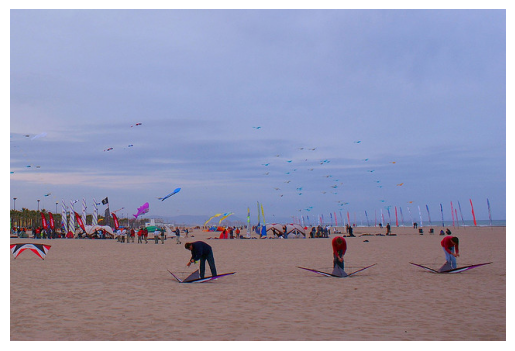

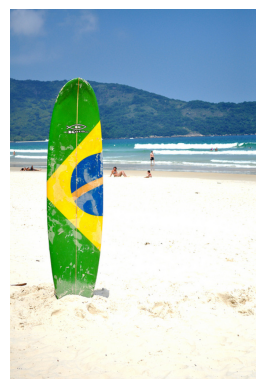

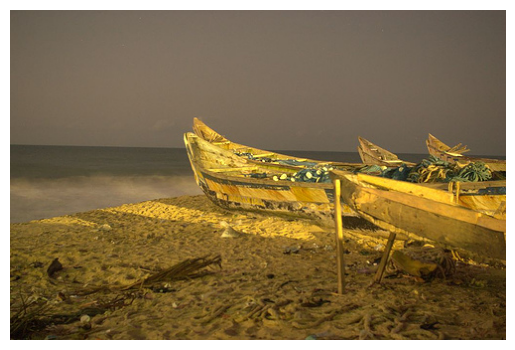

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
# Open the image file

while not pq.empty():

    image_path = pq.top()
    pq.pop()
    image = Image.open(image_path)  # Replace "image.jpg" with the file name of your image

    # Display the image
    image.show()
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [15]:
import pandas as pd
file_path = '/content/Caption_Database.xlsx'
df = pd.read_excel(file_path)

best_image_path = None
best_similarity = -1

for image_path, rows in df.items():

    image_embedding = []

    for value in rows:
        image_embedding.append(value)

    similarity_score = compute_similarity(input_embedding[0], image_embedding)

    # Update best match
    if similarity_score > best_similarity:
        best_similarity = similarity_score
        best_image_path = image_path

print(best_image_path)

        # Access the file and perform operations as needed


/content/images_folder/val2017/val2017/000000503823.jpg


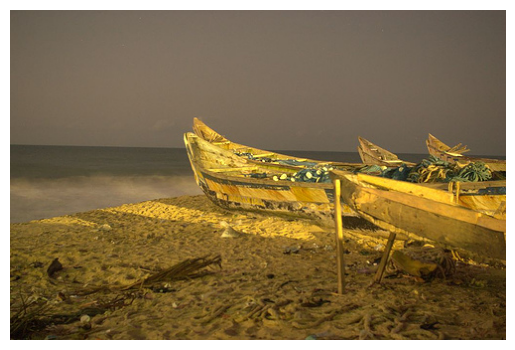

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
# Open the image file
image = Image.open(best_image_path)  # Replace "image.jpg" with the file name of your image

# Display the image
image.show()
plt.imshow(image)
plt.axis('off')
plt.show()


# Video Captioning

In [27]:
import cv2
import os

def extract_frames(video_path, frame_rate=2):
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_rate == 0:
            frame_list.append(frame)
        frame_count += 1

    cap.release()
    return frame_list

In [28]:
def frames_to_images(frames, temp_folder='/content/temp_frames'):
    if not os.path.exists(temp_folder):
        os.makedirs(temp_folder)

    image_paths = []
    for idx, frame in enumerate(frames):
        image_path = os.path.join(temp_folder, f"frame_{idx}.jpg")
        cv2.imwrite(image_path, frame)
        image_paths.append(image_path)

    return image_paths

In [29]:
def caption_video(video_path):
    frames = extract_frames(video_path, frame_rate=30)
    image_paths = frames_to_images(frames)
    captions = predict_step(image_paths)

    for image_path in image_paths:
        os.remove(image_path)  # Clean up the temporary images

    return captions

In [34]:
video_path = '/content/drive/MyDrive/video.mp4'
captions = caption_video(video_path)
for idx, caption in enumerate(captions):
    print(f"Frame {idx}: {caption}")

Frame 0: a man sitting on a bench in front of a house
Frame 1: a man sitting on a bench in front of a house
Frame 2: a man sitting on a bench in front of a house
Frame 3: a man sitting on a chair in front of a house
Frame 4: a man sitting on a chair in front of a house
Frame 5: a man sitting on a chair in front of a house
Frame 6: two people sitting on a horse in front of a house
Frame 7: a man riding on the back of a brown horse
Frame 8: a man sitting on top of a white horse in the grass
Frame 9: a man standing in front of a white house
Frame 10: a person riding a horse in a grassy field
Frame 11: a person standing in front of a house
Frame 12: a person standing in front of a house
Frame 13: a house with a dog sitting on the porch
Frame 14: a small house with a dog on the roof
Frame 15: a house with a wooden roof and a large window
Frame 16: a person sitting on a bench in a grassy area
Frame 17: a person standing in a grassy area next to a house
Frame 18: a white house with a blue roo

In [35]:
video_path = '/content/drive/MyDrive/video1.mp4'
captions = caption_video(video_path)
for idx, caption in enumerate(captions):
    print(f"Frame {idx}: {caption}")

Frame 0: a mountain range with snow capped mountains
Frame 1: a mountain range with snow capped mountains
Frame 2: a mountain range with snow capped mountains
Frame 3: a mountain range with snow capped mountains
Frame 4: a mountain range with snow capped mountains
Frame 5: a mountain range with snow capped mountains
Frame 6: a mountain range with snow capped mountains
Frame 7: a mountain range with snow capped mountains
Frame 8: a mountain range with snow capped mountains
Frame 9: a mountain range with snow capped mountains
Frame 10: a mountain range with snow capped mountains
Frame 11: a mountain range with snow capped mountains
Frame 12: a mountain range with snow capped mountains
Frame 13: a mountain range with snow capped mountains
Frame 14: a mountain range with snow capped mountains
Frame 15: a mountain range with snow capped mountains
Frame 16: a mountain range with snow capped mountains
Frame 17: a mountain range with snow capped mountains
Frame 18: a mountain range with snow c

In [36]:
video_path = '/content/drive/MyDrive/video2.mp4'
captions = caption_video(video_path)
for idx, caption in enumerate(captions):
    print(f"Frame {idx}: {caption}")

Frame 0: young men playing a game of frisbee
Frame 1: young women playing a game of soccer
Frame 2: young men playing a game of soccer
Frame 3: young men playing a game of soccer
Frame 4: young men playing a game of frisbee
Frame 5: a number of people on a basketball court
Frame 6: a basketball court with a basketball on it
Frame 7: a basketball game is being played on the court
Frame 8: a basketball court with a bunch of basketballs on it
